In [1]:
import tensorflow

from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())



[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1043036368663190315
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1746980046
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14693167194253847882
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


In [2]:
import os
import tensorflow

# '0번' GPU 사용
os.environ["CUDA_VISIBLE_DEVICES"]="0"
gpus = tensorflow.config.experimental.list_physical_devices('GPU')
tensorflow.config.experimental.set_visible_devices(gpus[0], 'GPU')

if gpus:
    try:
        tensorflow.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1" => cpu 사용 강제
# tensorflow.debugging.set_log_device_placement(True)

a = tensorflow.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
b = tensorflow.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
c = tensorflow.matmul(a, b)
print(c)

tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32)


In [4]:
from konlpy.tag import Mecab
mecab = Mecab(dicpath='C:/mecab/mecab-ko-dic')
# # out = mecab.parse("오늘은 맑은 날씨이다.")
# print(out)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
#임의로 열제목 추가
total_data = pd.read_table('steam.txt', names=['label', 'reviews'])
print('전체 리뷰 개수 :',len(total_data)) # 전체 리뷰 개수 출력
total_data[:5]

In [ ]:
# 각 열에 대해서 중복을 제외한 샘플의 수를 카운트합니다.
total_data['reviews'].nunique(), total_data['label'].nunique()

In [ ]:
total_data.drop_duplicates(subset=['reviews'], inplace=True) # reviews 열에서 중복인 내용이 있다면 중복 제거
print('총 샘플의 수 :',len(total_data))
# null 값 유무
print(total_data.isnull().values.any())


In [ ]:
train_data, test_data = train_test_split(total_data, test_size = 0.25, random_state = 42)
print('훈련용 리뷰의 개수 :', len(train_data))
print('테스트용 리뷰의 개수 :', len(test_data))
train_data['label'].value_counts().plot(kind = 'bar')
print(train_data.groupby('label').size().reset_index(name = 'count'))

In [ ]:
# 한글과 공백을 제외하고 모두 제거
train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data['reviews'].replace('', np.nan, inplace=True)
# null 값 체크
print(train_data.isnull().sum())

In [ ]:
test_data.drop_duplicates(subset = ['reviews'], inplace=True) # 중복 제거
test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['reviews'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

In [ ]:
#불용어 정의
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게', '만', '게임', '겜', '되', '음', '면']
# 토큰화 
mecab = Mecab(dicpath='C:/mecab/mecab-ko-dic')

train_data['tokenized'] = train_data['reviews'].apply(mecab.morphs)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])
test_data['tokenized'] = test_data['reviews'].apply(mecab.morphs)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

In [ ]:
negative_words = np.hstack(train_data[train_data.label == 0]['tokenized'].values)
positive_words = np.hstack(train_data[train_data.label == 1]['tokenized'].values)

negative_word_count = Counter(negative_words)
print(negative_word_count.most_common(20))

positive_word_count = Counter(positive_words)
print(positive_word_count.most_common(20))

In [ ]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
text_len = train_data[train_data['label']==1]['tokenized'].map(lambda x: len(x))
ax1.hist(text_len, color='red')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('length of samples')
ax1.set_ylabel('number of samples')
print('긍정 리뷰의 평균 길이 :', np.mean(text_len))

text_len = train_data[train_data['label']==0]['tokenized'].map(lambda x: len(x))
ax2.hist(text_len, color='blue')
ax2.set_title('Negative Reviews')
fig.suptitle('Words in texts')
ax2.set_xlabel('length of samples')
ax2.set_ylabel('number of samples')
print('부정 리뷰의 평균 길이 :', np.mean(text_len))
plt.show()

In [ ]:
X_train = train_data['tokenized'].values
y_train = train_data['label'].values
X_test= test_data['tokenized'].values
y_test = test_data['label'].values

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [ ]:
threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

In [ ]:
# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거.
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

In [ ]:
# word_to_index에는 빈도수가 높은 상위 5개의 단어만 저장되었습니다. word_to_index를 사용하여 단어 토큰화가
# 된 상태로 저장된 sentences에 있는 각 단어를 정수로 바꾸는 작업을 하겠습니다.

# 예를 들어 sentences에서 첫번째 문장은 ['barber', 'person']이었는데, 이 문장에 대해서는 [1, 5]로 인코딩합니다. 
# 그런데 두번째 문장인 ['barber', 'good', 'person']에는 더 이상 word_to_index에는 존재하지 않는 단어인 'good'이라는 단어가 있습니다.

# 이처럼 단어 집합에 존재하지 않는 단어들이 생기는 상황을 Out-Of-Vocabulary(단어 집합에 없는 단어) 문제라고 합니다.
# 약자로 'OOV 문제'라고도 합니다. word_to_index에 'OOV'란 단어를 새롭게 추가하고, 단어 집합에 없는 단어들은 'OOV'의 인덱스로 인코딩하겠습니다.

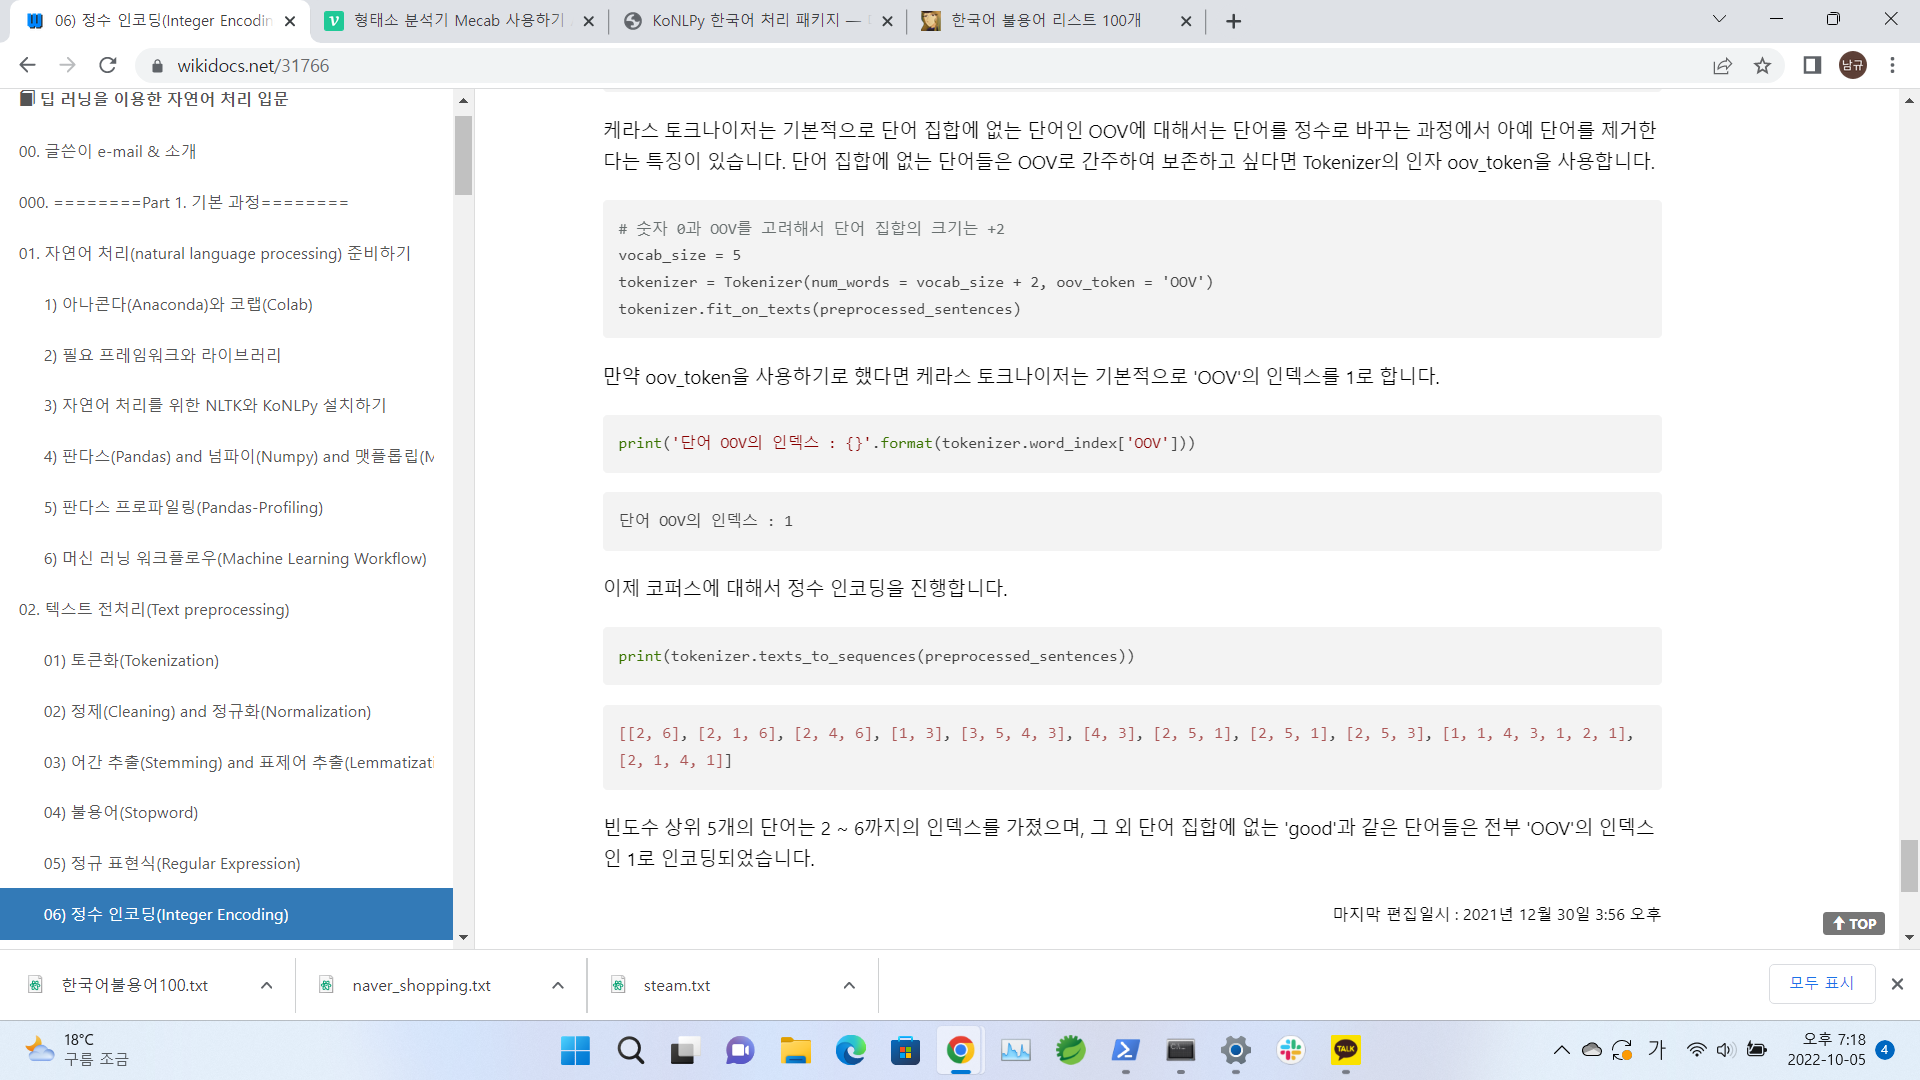

In [ ]:
#단어 집합의 크기는 18,941개입니다. 이를 토크나이저의 인자로 넘겨주면, 
#토크나이저는 텍스트 시퀀스를 숫자 시퀀스로 변환합니다. 이러한 정수 인코딩 과정에서 이보다 큰 숫자가 부여된 단어들은 OOV로 변환하겠습니다.
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
# fit_on_texts는 입력한 텍스트로부터 단어 빈도수가 높은 순으로 낮은 정수 인덱스를 부여하는데, 
# 정확히 앞서 설명한 정수 인코딩 작업이 이루어진다고 보면됩니다. 각 단어에 인덱스가 어떻게 부여되었는지를 보려면, word_index를 사용합니다.
tokenizer.fit_on_texts(X_train)
# texts_to_sequences()는 입력으로 들어온 코퍼스에 대해서 각 단어를 이미 정해진 인덱스로 변환합니다.
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [ ]:
max_len = 60
below_threshold_len(max_len, X_train)

In [ ]:
#패딩
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [ ]:
import re
from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(Bidirectional(LSTM(hidden_units))) # Bidirectional LSTM을 사용
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=256, validation_split=0.2)

loaded_model = load_model('best_model.h5')
print("테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

In [ ]:
print(vocab_size)

y_train[0:100]

In [ ]:
def sentiment_predict(new_sentence):
    new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
    new_sentence = mecab.morphs(new_sentence) # 토큰화
    new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
    encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
    pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
    score = float(loaded_model.predict(pad_new)) # 예측
    if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.".format(score * 100))
    else:
    print("{:.2f}% 확률로 부정 리뷰입니다.".format((1 - score) * 100))

In [ ]:
sentiment_predict('노잼 ..완전 재미 없음 ㅉㅉ')
sentiment_predict('조금 어렵지만 재밌음ㅋㅋ')
sentiment_predict('케릭터가 예뻐서 좋아요')


In [ ]:
# 1) morphs : 형태소 추출
# 2) pos : 품사 태깅(Part-of-speech tagging)
# 3) nouns : 명사 추출

In [ ]:
sentiment_predict('아 이거 하다가 시간 가는줄 몰랐음 ㅋㅋ')
sentiment_predict('ㄹㅇ 꿀잼 ㅋㅋ')

In [ ]:
sentiment_predict('영양만점 세진총각! 인기만점 세진총각! 너무너무 좋아용~!')

In [ ]:
sentiment_predict('페이데이 ㄹㅇ 갓겜 ㄷㄷ')

In [ ]:
sentiment_predict('존나 재밋누 ㅎ')

In [ ]:
sentiment_predict('게임 ㅆㅅㅌㅊ')

In [ ]:
sentiment_predict('게임 ㅆㅎㅌㅊ')

In [ ]:
sentiment_predict('단무지가 노란게 맛있노')

In [4]:
# 필요한 라이브러리를 임포트하기

import sys # 시스템
import os  # 시스템

# 데이터 다루기
import pandas as pd
import numpy as np

# selenium 크롤링
from selenium import webdriver  
from selenium.webdriver import ActionChains as AC
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By

# 크롬 드라이버
import chromedriver_autoinstaller

# beautifulsoup 크롤링
import requests
from bs4 import BeautifulSoup

# lxml 크롤링
import lxml.html

# 시간 조절
import time

# 시간 측정
from tqdm import notebook

# 정규표현식
import re

# 경고 무시
import warnings
warnings.filterwarnings('ignore')


from selenium.webdriver.common.keys import Keys

keyword = ['삼겹살', '떡볶이', '곱창', '국밥']

# 크롬창 띄우기
chrome_path = chromedriver_autoinstaller.install()
driver = webdriver.Chrome(chrome_path)
driver.maximize_window() # 창 최대화

# 키워드가 입력된 망고플레이트 사이트에 들어가기
driver.get("https://www.mangoplate.com/search/{0}?keyword={0}".format(keyword)) 
time.sleep(2)

# 광고창 iframe 접근하기
driver.switch_to.frame("google_ads_iframe_/395211568/init/desktop_all_0")

# '다시 보지 않기' 버튼 클릭하기
element = '#ad > div > button.ad_btn.ad_block_btn'
driver.find_element_by_css_selector(element).click()
time.sleep(2)


page = 50




In [ ]:


for key in keyword:
    print(key)
    review_list[key] = []
    for i in range(1, page):
        driver.get("https://www.mangoplate.com/search/{0}?keyword={0}&page={1}".format(key, i)) 
        time.sleep(1)
        
        for i in range(1, 4):
            for j in range(1,3):
                review_tmp = []

                xpath = "/html/body/main/article/div[2]/div/div/section/div[3]/ul/li[{0}]/div[{1}]/figure/figcaption/div/a".format(i, j)
                print(xpath)
                driver.find_element(By.XPATH,xpath).send_keys(Keys.ENTER)
                time.sleep(1)
                
                for k in range(1, 6):
                    xpath = """/html/body/main/article/div[1]/div[1]/div/section[3]/ul/li[{0}]/a/div[2]/div/p""".format(k)
                    try:
                        review = driver.find_element(By.XPATH,xpath)
                        text_tmp = ''
                        for text in review.text.split('\n'):
                            if text not in ['', ',', '.']:
                                text_tmp += text
                        review_list[key].append(text_tmp)
                    except:
                        print("break")
                        break
                    # time.sleep(1)
                # 뒤로 가기
                driver.back()
                time.sleep(1)

                
                

In [206]:

for review in review_list:
    print(review_list[review][:1])
    pd.DataFrame(review_list[review])

categorical_data = {}
# [0 : '삼겹살', 1 : '떡볶이', 2: '곱창', 3: '국밥']
cnt = 0
for review in review_list:
    categorical_data[cnt] = review_list[review]
    cnt += 1

text_list = []
for i in range(0, 4):
    text_list.append(pd.DataFrame({'reviews' : categorical_data[i],
                                  'label' : i}))


total_data = pd.concat([text_list[0], text_list[1], text_list[2], text_list[3]])

KeyError: 0

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from konlpy.tag import Mecab

import numpy as np
import pandas as pd

mecab = Mecab(dicpath='C:/mecab/mecab-ko-dic')

total_data = pd.read_csv('total_data.csv')

review_list = {}

import re
#뛰어쓰기 수정
from pykospacing import Spacing
spacing = Spacing()
#맞춤법 수정
from hanspell import spell_checker

import sys
import soynlp
from soynlp.normalizer import *

def text_process(text):
    m = re.search('ㅋ+|ㅠ+|ㅜ+', text)
    if m:
        tmp = spacing(text)
        tmp = spell_checker.check(tmp)[2]
        tmp = emoticon_normalize(tmp)
        tmp = re.sub('ㅋ+|ㅠ+|ㅜ+', '', tmp)
        tmp = repeat_normalize(tmp, num_repeats=1)
        return tmp

    else :
        tmp = text
    tmp = spacing(tmp)
    tmp = spell_checker.check(tmp)[2] 
            
    return tmp

In [3]:
total_data

,reviews,label
0,1. 개인적으로 연예인들이 추천하는 맛집을 크게 신뢰하진 않는 편이었다. 하지만 최...,0
1,길목은 맛있다. 웨이팅은 너무하지만 맛있는 고기임은 확실함. 고기가 아주 싱싱해서 ...,0
2,맛있다는 얘기를 많이 듣기는 했었지만 사실 속으로 유명해서 유명해진 돼지고기집일 수...,0
3,그 유명하다는 길목! 몇 년 전부터 정말 가보고 싶었는데 드디어 소원 이뤘지만 너무...,0
4,명불허전 길목의 목살.암퇘지 전문점 길목이다. 서울 3대 목살이라 하는데 인정할 수...,0
...,...,...
3446,잘 먹자 어찌 됐든 밥 챙겨 먹자. 그저 사는 게 아닌 잘 먹는 것이 잘 삶이다. ...,3
3447,아무런 기대없이 한끼 때우려들어갔는대 맛있어서 놀란 곳. 가게에서 직접 우려내는 육...,3
3448,0. 아침 일찍 문여는 몇 안되는 집. 지금은 바로 앞에 길동우동(8시 오픈)이 상...,3
3449,"먹방 유투버 국밥부장관(액션홍구)이 극찬했다는 바로 그 집, 충남 아산 꽃돼지국밥!...",3


In [275]:
total_data['reviews'].nunique(), total_data['label'].nunique()
total_data.drop_duplicates(subset=['reviews'], inplace=True) # reviews 열에서 중복인 내용이 있다면 중복 제거
print('총 샘플의 수 :',len(total_data))
print(total_data.isnull().values.any())


train_data, test_data = train_test_split(total_data, test_size = 0.1, random_state = 20)
print('훈련용 리뷰의 개수 :', len(train_data))
print('테스트용 리뷰의 개수 :', len(test_data))

총 샘플의 수 : 3371
True
훈련용 리뷰의 개수 : 3033
테스트용 리뷰의 개수 : 338


In [276]:
# 한글과 공백을 제외하고 모두 제거
train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data['reviews'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())
train_data = train_data.dropna(how='any') # Null 값 제거

test_data.drop_duplicates(subset = ['reviews'], inplace=True) # 중복 제거
test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['reviews'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 훈련용 샘플의 개수 :',len(train_data))
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))
####################################################################
train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)
####################################################################
for i in range(0, len(train_data['reviews'])):
    train_data['reviews'][i] = text_process(train_data['reviews'][i])
for i in range(0, len(test_data['reviews'])):
    test_data['reviews'][i] = text_process(test_data['reviews'][i])

    # 한글과 공백을 제외하고 모두 제거
train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data['reviews'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())
train_data = train_data.dropna(how='any') # Null 값 제거

test_data.drop_duplicates(subset = ['reviews'], inplace=True) # 중복 제거
test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['reviews'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 훈련용 샘플의 개수 :',len(train_data))
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)
    

reviews    5
label      0
dtype: int64
전처리 후 훈련용 샘플의 개수 : 3028
전처리 후 테스트용 샘플의 개수 : 338
reviews    339
label        0
dtype: int64
전처리 후 훈련용 샘플의 개수 : 2689
전처리 후 테스트용 샘플의 개수 : 304


In [277]:
train_data.to_csv("train_data.csv", index = False)
test_data.to_csv("test_data.csv", index = False)

In [278]:
train_data = pd.read_csv('train_data.csv')
test_data = pd.read_csv('test_data.csv')

In [279]:
#불용어 정의
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게', '만', '게임', '겜', '되', '음', '면']
stop = """이	VCP	0.018279601
있	VA	0.011699048
하	VV	0.009773658
것	NNB	0.00973315
들	XSN	0.00689824
그	MM	0.005327252
되	VV	0.00361335
수	NNB	0.003473622
이	NP	0.003361203
보	VX	0.003310379
않	VX	0.0029757
없	VA	0.002920476
나	NP	0.002690479
사람	NNG	0.002073917
주	VV	0.001884579
아니	VCN	0.001870774
등	NNB	0.001822074
같	VA	0.001724522
우리	NP	0.001714509
때	NNG	0.001685684
년	NNB	0.001647755
가	VV	0.001618626
한	MM	0.001584036
지	VX	0.001537763
대하	VV	0.00150378
오	VV	0.001490884
말	NNG	0.001321876
일	NNG	0.001239799
그렇	VA	0.001232062
위하	VV	0.001170618
때문	NNB	0.001146647
그것	NP	0.001099161
두	VV	0.001063053
말하	VV	0.001030587
알	VV	0.000995693
그러나	MAJ	0.000978246
받	VV	0.000924084
못하	VX	0.000904665
일	NNB	0.000880239
그런	MM	0.000879481
또	MAG	0.000870985
문제	NNG	0.000823954
더	MAG	0.000801652
사회	NNG	0.000793459
많	VA	0.000789211
그리고	MAJ	0.000779653
좋	VA	0.000763723
크	VA	0.000758565
따르	VV	0.000738084
중	NNB	0.000733229
나오	VV	0.000725188
가지	VV	0.000720485
씨	NNB	0.000710169
시키	XSV	0.000707893
만들	VV	0.000703797
지금	NNG	0.000699701
생각하	VV	0.000694846
그러	VV	0.000692418
속	NNG	0.00068544
하나	NR	0.000655097
집	NNG	0.000648573
살	VV	0.000648422
모르	VV	0.000645084
적	XSN	0.000643112
월	NNB	0.000639319
데	NNB	0.000636436
자신	NNG	0.000632188
안	MAG	0.000625968
어떤	MM	0.000623237
내	NP	0.000622023
내	VV	0.000614438
경우	NNG	0.000613831
명	NNB	0.00061019
생각	NNG	0.000587433
시간	NNG	0.00057302
그녀	NP	0.000571806
다시	MAG	0.00055618
이런	MM	0.000550263
앞	NNG	0.000548898
보이	VV	0.000542678
번	NNB	0.000542526
나	VX	0.000538126
다른	MM	0.000536306
어떻	VA	0.000533423
여자	NNG	0.000531754
개	NNB	0.000530085
전	NNG	0.00052872
들	VV	0.000514914
사실	NNG	0.000511728
이렇	VA	0.000511576
점	NNG	0.000507935
싶	VX	0.000504749
말	VX	0.000503991
정도	NNG	0.000496102
좀	MAG	0.000492916
원	NNB	0.000492309
잘	MAG	0.000491399
통하	VV	0.000486847
소리	NNG	0.000485633
놓	VX	0.000482751
"""

stoplist = re.split(r'[+ + \t + \n]', stop)
# stoplist = re.split(r'[가-힣]', stop)
# stoplist = re.compile('[가-힣]').findall(stop)
for i in range(0, len(stoplist), 3):
    stopwords.append(stoplist[i])
stopwords= [s for s in stopwords if s != '']

train_data['tokenized'] = train_data['reviews'].apply(mecab.morphs)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])
test_data['tokenized'] = test_data['reviews'].apply(mecab.morphs)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])


train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)


#너무 짧은 리뷰는 제거
for i in range(1, len(train_data['tokenized'])):
    if len(train_data['tokenized'][i]) < 2:
        print(train_data['tokenized'][i])
        train_data = train_data.drop([i],axis = 0)
        

for i in range(1, len(test_data['tokenized'])):
    if len(test_data['tokenized'][i]) < 2:
        print(test_data['tokenized'][i])
        test_data = test_data.drop([i],axis = 0)
        
train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)


X_train = train_data['tokenized'].values
y_train = train_data['label'].values
X_test= test_data['tokenized'].values
y_test = test_data['label'].values

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

['무난']
['맛있']
['그냥']
['평범']
['비싸']
['개안']
['ㅇ']
['방문']
['맛있']
['ㅌ']
['괜찮']
['곱창']
['겹']
['ㅎ']
['맛있']
['구성비']
['굿']
['불친절']
['굿']


In [280]:

threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold , rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)


단어 집합(vocabulary)의 크기 : 10074
등장 빈도가 2번 이하인 희귀 단어의 수: 4562
단어 집합에서 희귀 단어의 비율: 45.284891800675005
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.392628729511854


In [281]:
# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거.
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)

단어 집합의 크기 : 5514


In [282]:
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
def below_threshold_len(max_len, nested_list):
    count = 0
    for sentence in nested_list:
        if(len(sentence) <= max_len):
            count = count + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

max_len = 300
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 300 이하인 샘플의 비율: 100.0


In [283]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [4]:
from gensim.models import fasttext

model = fasttext.load_facebook_model('cc.ko.300.bin')

In [7]:
emotions = ['가성비', '술집', '분위기', '청결', '맛집', '뷰', '한적', '시끌벅적', '활동적','기념일', '고급진', '감성적', '가족', '전통적', '모던한', '편안한', '색다른',
'애견동반', '편리한', '이국적']

In [8]:
for i in emotions:
    try:
        print(model.wv.key_to_index[i])
    except:
        print('null')
        

3795
32063
5266
49905
2839
8210
157658
186566
174207
22264
141905
54468
612
8467
23000
2372
11494
1294436
4782
149672


In [25]:
tmp = []
for i in emotions:
    tmp.append(model.wv.most_similar(i))

In [26]:
tmp

[[('719위', 0.6658939719200134),
  ('234위', 0.6524614095687866),
  ('467위', 0.6508278250694275),
  ('445위', 0.6381197571754456),
  ('321위', 0.6291288137435913),
  ('514위', 0.6279513239860535),
  ('634위', 0.6203398108482361),
  ('384위', 0.6199716329574585),
  ('713위', 0.6112664937973022),
  ('839위', 0.6007509827613831)],
 [('주점', 0.5747563242912292),
  ('술집과', 0.5621869564056396),
  ('밥집', 0.5430620312690735),
  ('피자집', 0.5342158079147339),
  ('삐끼', 0.5339789390563965),
  ('방석집', 0.5329165458679199),
  ('유흥', 0.5316259860992432),
  ('여종업원', 0.5313736796379089),
  ('맥주집', 0.5231595635414124),
  ('닭집', 0.5210198163986206)],
 [('분위기를', 0.671783983707428),
  ('분위기와', 0.6558778882026672),
  ('분위기가', 0.6548929214477539),
  ('분위기도', 0.6394948959350586),
  ('분위기는', 0.63541179895401),
  ('분위기에', 0.5868253707885742),
  ('분위기로', 0.5808834433555603),
  ('분위기의', 0.57512366771698),
  ('분위기에서', 0.5464282631874084),
  ('01년생의', 0.5455527901649475)],
 [('위생', 0.5843746662139893),
  ('청결함', 0.584002435207

In [285]:
#단어집합
tmp = []
#문장집합
sen_tmp = []

for words in train_data['tokenized']:
    sen_tmp.append(words)
    for word in words:
        tmp.append(word)
        
result = list(dict.fromkeys(tmp))
print(len(result), vocab_size)

cnt = 0

for k in tokenizer.word_index:
    if k not in model.wv.key_to_index:
        cnt += 1
        
print(cnt)

embedding_matrix = np.zeros((vocab_size, 300))

print(vocab_size)
print(len(embedding_matrix), len(tokenizer.word_index))

10074 5514
958
5514
5514 10075


In [286]:
#임베딩학습단어에 있는 단어 집합
in_tmp = []
for word in tmp:
    if word in model.wv.key_to_index :
        in_tmp.append(word)
        
#임베딩학습단어에 없는 단어 집합
notin_tmp = []      
for word in tmp:
    if word not in model.wv.key_to_index :
        notin_tmp.append(word)
        
for i in range(1, len(embedding_matrix)):
    for word in tokenizer.word_index:
        if word in model.wv.key_to_index:
            embedding_matrix[i] = model.wv.vectors[model.wv.key_to_index[word]]


In [287]:
import tensorflow as tf

class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = Dense(units)
        self.W2 = Dense(units)
        self.V = Dense(1)

    def call(self, values, query): # 단, key와 value는 같음
        # query shape == (batch_size, hidden size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden size)
        # score 계산을 위해 뒤에서 할 덧셈을 위해서 차원을 변경해줍니다.
        hidden_with_time_axis = tf.expand_dims(query, 1)

        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = self.V(tf.nn.tanh(
            self.W1(values) + self.W2(hidden_with_time_axis)))

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights


In [344]:
from tensorflow.keras.layers import Dense, Embedding, Bidirectional, LSTM, Concatenate, Dropout, Flatten, Activation,BatchNormalization
from tensorflow.keras import Input, Model, layers, optimizers, metrics
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow
import numpy as np
import matplotlib.pyplot as plt
import h5py




model_name = 'text_classify'
batch_size = 64
num_epochs = 20
valid_split = 0.1
# input_sequence = Input(shape=(max_len,), dtype='int32')

# kargs = {'model_name' : model_name,
#         'vacab_size' : vocab_size,
#          'max_len': max_len,
#         'embedding_size' : 300,
#          'embedding_matrix' : embedding_matrix,
#          'lstm_size' : 150,
#         'dropout_rate' : 0.5,
#         'hidden_dimension' : 250,
#         'output_dimension' : 1}




# class text_classify(tf.keras.Model):
#     def __init__(self, **kargs):
#         super(text_classify, self).__init__(name=kargs['model_name'])
#         # self.input_sequence = Input(shape=(kargs['max_len'],), dtype='int32')

#         self.custom_embedding = layers.Embedding(input_dim=kargs['vacab_size'],
#                                          output_dim=kargs['embedding_size'],
#                                          weights=[kargs['embedding_matrix']],
#                                          input_length=kargs['max_len'], 
#                                          trainable=True
#                                          )
        
#         self.custom_lstm = Bidirectional(LSTM(kargs['lstm_size'], 
#                                        dropout=kargs['dropout_rate'], 
#                                        return_sequences = True))
        
#         self.custom_lstm_2 = Bidirectional(LSTM(kargs['lstm_size'], dropout=kargs['dropout_rate'],
#                            return_sequences=True, return_state=True))
        
# #         self.tmp = self.custom_lstm(self.custom_embedding)
  
#         self.custom_lstm, self.forward_h, self.forward_c, self.backward_h, self.backward_c = self.custom_lstm_2
        
#         self.state_h = Concatenate()([self.forward_h, self.backward_h]) # 은닉 상태
#         self.state_c = Concatenate()([self.forward_c, self.backward_c]) # 셀 상태
     
#         self.custom_attention = BahdanauAttention(64) # 가중치 크기 정의
#         self.context_vector, self.attention_weights = self.custom_attention(self.custom_lstm, self.state_h)

#         self.custom_dense1 = Dense(64, activation="elu")
#         self.custom_dropout = Dropout(0.5)
#         self.output_layer = Dense(4, activation="softmax")
        
#         # self.tmp_2 = self.output_layer(self.custom_dropout(self.custom_dense1(self.context_vector)))
        
#         # self.custom_model = Model(inputs=self.input_sequence, outputs=self.tmp_2)
    
#     def lstm_tmp(self, x):
#         return Bidirectional(LSTM(kargs['lstm_size'], dropout=kargs['dropout_rate'],
#                            return_sequences=True, return_state=True))(x)
#     def call(self, x):
#         # print(x)
#         # print(self)
#         # print(type(x))
#         # for i in x:
#         #     print(i)
#         #     print(type(i))
#         # print(type(self.input_sequence))
#         # x = self.input_sequence
#         x = self.custom_embedding(x)
#         x = self.custom_lstm(x)
#         self.custom_lstm, self.forward_h, self.forward_c, self.backward_h, self.backward_c = self.custom_lstm_2(x)
#         self.state_h = Concatenate()([self.forward_h, self.backward_h]) # 은닉 상태
#         self.state_c = Concatenate()([self.forward_c, self.backward_c]) # 셀 상태
#         self.custom_attention = BahdanauAttention(64)
#         self.context_vector, self.attention_weights = self.custom_attention(self.custom_lstm, self.state_h)
           
#         x = self.custom_dense1(self.context_vector)
#         x = self.custom_dropout(x)
#         x = self.output_layer(x)
#         # self.custom_model = Model(inputs=self.input_sequence, outputs=x)
        
#         return x
        

#     def get_config(self):
#         config = super().get_config().copy()
#         config.update({'model_name' : self.model_name,
#         'vacab_size' : self.vocab_size,
#          'max_len': self.max_len,
#         'embedding_size' : 300,
#          'embedding_matrix' : self.embedding_matrix,
#          'lstm_size' : 150,
#         'dropout_rate' : 0.5,
#         'hidden_dimension' : 250,
#         'output_dimension' : 1})
#         return config

    
# text_model = text_classify(**kargs)

# sequence_input = Input(shape=(max_len,), dtype='int32')
# embedded_sequences = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_len, trainable=True)(sequence_input)

# lstm = Bidirectional(LSTM(150, dropout=0.5, return_sequences = True))(embedded_sequences)

# lstm, forward_h, forward_c, backward_h, backward_c = Bidirectional(LSTM(150, dropout=0.5, return_sequences=True, return_state=True))(lstm)


# state_h = Concatenate()([forward_h, backward_h]) # 은닉 상태
# state_c = Concatenate()([forward_c, backward_c]) # 셀 상태

# attention = BahdanauAttention(64) # 가중치 크기 정의
# context_vector, attention_weights = attention(lstm, state_h)

# dense1 = Dense(64, activation="elu")(context_vector)
# dropout = Dropout(0.5)(dense1)
# output = Dense(4, activation="softmax")(dropout)
# model = Model(inputs=sequence_input, outputs=output)

# model.compile(loss='sparse_categorical_crossentropy', optimizer='Nadam', metrics=['accuracy'])
# input_sequence = Input(shape=(max_len,), dtype='int32')

kargs = {'vocab_size' : vocab_size,
         'max_len': max_len,
        'embedding_size' : 300,
         'embedding_matrix' : [embedding_matrix],
         'lstm_size' : 256,
        'dropout_rate' : 0.3,
        'hidden_dimension' : 250,
        'output_dimension' : 1}

def bi_lstm(**kargs):
    sequence_input = Input(shape=(kargs['max_len'],), dtype='int32')
    embedded_sequences = Embedding(kargs['vocab_size'], kargs['embedding_size'], weights=kargs['embedding_matrix'], input_length=kargs['max_len'], trainable=True)(sequence_input)

    lstm = Bidirectional(LSTM(kargs['lstm_size'], dropout=kargs['dropout_rate'],  return_sequences = True))(embedded_sequences)

    lstm, forward_h, forward_c, backward_h, backward_c = Bidirectional(LSTM(kargs['lstm_size'], dropout=kargs['dropout_rate'], return_sequences=True, return_state=True))(lstm)


    state_h = Concatenate()([forward_h, backward_h]) # 은닉 상태
    state_c = Concatenate()([forward_c, backward_c]) # 셀 상태

    attention = BahdanauAttention(128) # 가중치 크기 정의
    context_vector, attention_weights = attention(lstm, state_h)

    # hidden = BatchNormalization()(context_vector)
    dense1 = Dense(128, activation="elu")(context_vector)
    dropout_1 = Dropout(0.5)(dense1)
    dense2 = Dense(64, activation="elu")(dropout_1)
    dropout_2 = Dropout(0.5)(dense2)
    # dense3 = Dense(32, activation="elu")(dropout_2)
    # dropout_3 = Dropout(0.5)(dense3)
    dense4 = Dense(16, activation="elu")(dropout_2)
    dropout_4 = Dropout(0.5)(dense4)
    # dense5 = Dense(8, activation="elu")(dropout_4)
    # dropout_5 = Dropout(0.5)(dense5)
    output = Dense(4, activation="softmax")(dropout_4)
    model = Model(inputs=sequence_input, outputs=output)
    Nadam = tf.keras.optimizers.Nadam(learning_rate=0.001)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=Nadam, metrics=['accuracy'])
    return model


#최적화 과정
modelpath = "Text/check/Text_train.hdf5"
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=2, save_best_only=True)
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)



#model 함수 : build
#build 는 class로 model 구성할때만 필요
#Sequential() -> model.add 하면 build 필요 x
#build 할때 size 필요
# (batch_size, params['input_dimension']) -> (row, col) size를 파라미터로
# # 이 parameter의 batch_size는 행의 크기만 전달
# model.build((64, vocab_size))
# model.summary()



In [345]:
np.shape(embedding_matrix)

(5514, 300)

In [346]:
text_model = bi_lstm(**kargs)

In [347]:
text_model.summary()

Model: "model_38"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_41 (InputLayer)          [(None, 300)]        0           []                               
                                                                                                  
 embedding_40 (Embedding)       (None, 300, 300)     1654200     ['input_41[0][0]']               
                                                                                                  
 bidirectional_81 (Bidirectiona  (None, 300, 512)    1140736     ['embedding_40[0][0]']           
 l)                                                                                               
                                                                                                  
 bidirectional_82 (Bidirectiona  [(None, 300, 512),  1574912     ['bidirectional_81[0][0]']

In [348]:
# history = model.fit(X_train, y_train, epochs = 7, batch_size = 128, validation_data=(X_test, y_test), verbose=2)
text_model = bi_lstm(**kargs)

history = text_model.fit(X_train, y_train, epochs = 50, batch_size = 32, validation_data=(X_test, y_test), verbose=2,
                   callbacks=[early_stopping_callback])


Epoch 1/50
84/84 - 15s - loss: 1.3971 - accuracy: 0.2588 - val_loss: 1.3995 - val_accuracy: 0.2664 - 15s/epoch - 178ms/step
Epoch 2/50
84/84 - 9s - loss: 1.3922 - accuracy: 0.2719 - val_loss: 1.3871 - val_accuracy: 0.2664 - 9s/epoch - 108ms/step
Epoch 3/50
84/84 - 9s - loss: 1.3873 - accuracy: 0.2764 - val_loss: 1.3886 - val_accuracy: 0.2664 - 9s/epoch - 110ms/step
Epoch 4/50
84/84 - 9s - loss: 1.3898 - accuracy: 0.2712 - val_loss: 1.3875 - val_accuracy: 0.2664 - 9s/epoch - 108ms/step
Epoch 5/50
84/84 - 9s - loss: 1.3865 - accuracy: 0.2880 - val_loss: 1.3862 - val_accuracy: 0.2664 - 9s/epoch - 107ms/step
Epoch 6/50
84/84 - 9s - loss: 1.4460 - accuracy: 0.2816 - val_loss: 1.3858 - val_accuracy: 0.2664 - 9s/epoch - 110ms/step
Epoch 7/50
84/84 - 9s - loss: 1.3161 - accuracy: 0.3483 - val_loss: 1.1890 - val_accuracy: 0.4211 - 9s/epoch - 109ms/step
Epoch 8/50
84/84 - 9s - loss: 1.1729 - accuracy: 0.4498 - val_loss: 1.0828 - val_accuracy: 0.4605 - 9s/epoch - 108ms/step
Epoch 9/50
84/84 - 9s 

10/10 [==============================] - 1s 42ms/step - loss: 1.2348 - accuracy: 0.7697
Test Accuracy: 0.7697


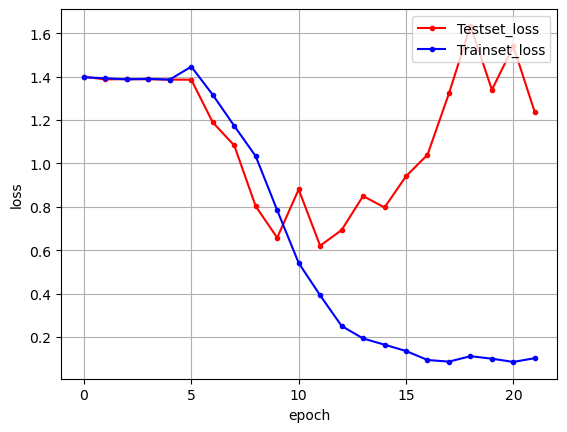

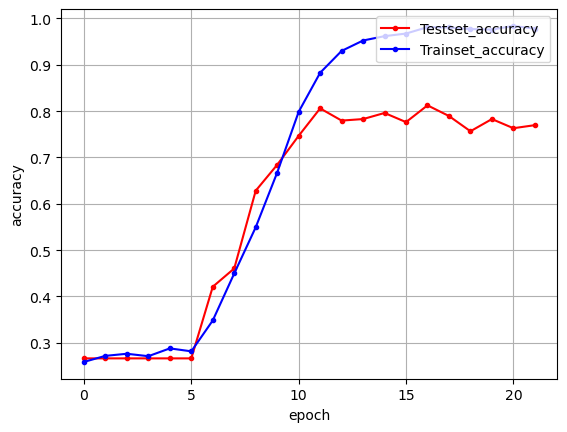

In [349]:


print("Test Accuracy: %.4f" % (text_model.evaluate(X_test, y_test)[1]))

y_vloss = history.history['val_loss']
y_loss = history.history['loss']

# 그래프로 표현해 보겠습니다.
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c="red", label='Testset_loss')
plt.plot(x_len, y_loss, marker='.', c="blue", label='Trainset_loss')

# 그래프에 그리드를 주고 레이블을 표시하겠습니다. 
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

y_vloss = history.history['val_accuracy']
y_loss = history.history['accuracy']

# 그래프로 표현해 보겠습니다.
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c="red", label='Testset_accuracy')
plt.plot(x_len, y_loss, marker='.', c="blue", label='Trainset_accuracy')

# 그래프에 그리드를 주고 레이블을 표시하겠습니다. 
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()


In [29]:
def get_vector(word):
    if word in model.wv.key_to_index:
        return model.wv.vectors[model.wv.key_to_index[word]]
    else:
        return None

In [27]:
old_vector_tmp = []
for i in notin_tmp:
    old_vector_tmp.append(np.copy(model.wv[i]))

In [28]:
new_sentences = sen_tmp

In [29]:
model.build_vocab(new_sentences, update=True)

In [30]:
model.train(new_sentences, total_examples=len(new_sentences), epochs=model.epochs)

(1575, 4000)

In [31]:
old_vector_tmp
for vector, word in zip(old_vector_tmp, notin_tmp):
    new_vector = model.wv[word]
    np.allclose(vector, new_vector, atol=1e-4)

In [32]:
len(model.wv.key_to_index)

2000001

In [13]:
import numpy as np
old_word = np.copy(model.wv['어쩔티비'])
model.build_vocab(update=True)

TypeError: Either one of corpus_file or corpus_iterable value must be provided

In [114]:
model = FastText(vector_size=4, window=3, min_count=1)  

In [113]:
model.wv

In [130]:
model.wv.key_to_index

{}

In [121]:
print(model.wv['대한'])

AttributeError: 'NoneType' object has no attribute 'shape'

In [98]:
print(model.wv.most_similar('teacher'))

[('teachers', 0.7598159909248352), ('teaches', 0.7168221473693848), ('teach', 0.6129273772239685), ('teaching', 0.5947589874267578), ('preacher', 0.5614587664604187), ('Teacher', 0.5571809411048889), ('educator', 0.5329986214637756), ('Educator', 0.5107240080833435), ('teachings', 0.5105742812156677), ('Teachers', 0.503318727016449)]


In [89]:
import chardet
# 인코딩 알아내기
print (chardet.detect (b'\xed\xa1\x9c'))

{'encoding': 'Windows-1252', 'confidence': 0.73, 'language': ''}


In [95]:
b'\xed\xa7\x80'.decode('Windows-1252')


'í§€'

In [101]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten

e = Embedding(100, 100, weights=[model], input_length=max_len, trainable=True)